---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [265]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [266]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [316]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    # A university town is a city which has a high percentage of university students 
    # compared to the total population of the city.
    college_towns = pd.read_table("university_towns.txt", header=None)
    # http://stackoverflow.com/questions/41457322/pandas-rearranging-a-data-frame/41458629#41458629
    college_towns['State'] = college_towns[0].str.extract('(.*)\[edit\]', expand=False).ffill()
    college_towns['RegionName'] = college_towns[0].str.replace(r'\s+\(.+$', '')
    college_towns = college_towns[~college_towns[0].str.contains('\[edit\]')].reset_index(drop=True).drop(0, axis=1)
    
    return college_towns

In [72]:
#get_list_of_university_towns()

In [73]:
df = get_list_of_university_towns()
print(df.loc[184,])
df.head()

State                                             Massachusetts
RegionName    The Five College Region of Western Massachusetts:
Name: 184, dtype: object


,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


## Read In + Clean GDP Data

In [74]:
# Read in GDP over time data
GDP = pd.read_excel("gdplev.xls", skiprows={0,1,2,3,4,6,7})
GDP.rename(columns={'Unnamed: 0': 'Year', 'Unnamed: 3': 'Quarter', 'Unnamed: 4': 'Year_Quarter', 'GDP in billions of current dollars.1': 'GDP_Billions'}, inplace=True)

# use the chained value in 2009 dollars
GDP.drop({'GDP in billions of current dollars', 'GDP in billions of chained 2009 dollars', 'Unnamed: 7', 'GDP in billions of chained 2009 dollars.1'},inplace=True,axis=1)

# Split Column into Year and Quarter
# http://stackoverflow.com/questions/14745022/pandas-dataframe-how-do-i-split-a-column-into-two
GDP['Year'] = GDP['Year_Quarter'].str.split('q', 1).str[0].astype(int)
GDP['Quarter'] = GDP['Year_Quarter'].str.split('q', 1).str[1].astype(int)
# For this assignment, only look at GDP data from the first quarter of 2000 onward.
GDP = GDP[GDP['Year'] >= 2000]

GDP.head(20)

,Year,Quarter,Year_Quarter,GDP_Billions
212,2000,1,2000q1,10031.0
213,2000,2,2000q2,10278.3
214,2000,3,2000q3,10357.4
215,2000,4,2000q4,10472.3
216,2001,1,2001q1,10508.1
217,2001,2,2001q2,10638.4
218,2001,3,2001q3,10639.5
219,2001,4,2001q4,10701.3
220,2002,1,2002q1,10834.4
221,2002,2,2002q2,10934.8


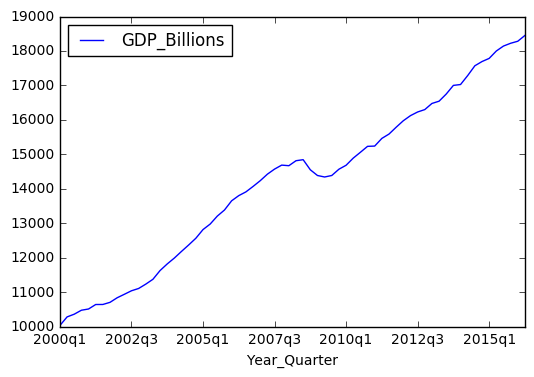

In [75]:
# http://pandas.pydata.org/pandas-docs/stable/visualization.html
import matplotlib.pyplot as plt

GDP.plot(x='Year_Quarter', y='GDP_Billions')
plt.show()

In [76]:
# A recession is defined as starting with two consecutive quarters of GDP decline, 
# and ending with two consecutive quarters of GDP growth.

In [88]:
# http://stackoverflow.com/questions/41361537/find-two-consecutive-quarters-of-gdp-decline-and-ending-with-two-consecutive-qu
# given dataframe GDP, returns the start_index and end_index for recession, as well as the index for the lowest point (bottom)

def get_recession(): 
    start_index = 0
    end_index = 0
    bottom = (0, float("inf"))
    recession = False # save current status of economy, assuming that we did not begin with a recession

    # start from 2nd quarter, so comparison begins with index i-1
    for i in range(1, len(GDP) - 1):
        # print(GDP['Year_Quarter'].iloc[i], GDP['GDP_Billions'].iloc[i])
        if not recession and (GDP['GDP_Billions'].iloc[i-1] > GDP['GDP_Billions'].iloc[i] > GDP['GDP_Billions'].iloc[i+1]):
            recession = True
            start_index = i-1
        elif recession:
            if (GDP['GDP_Billions'].iloc[i-1] < GDP['GDP_Billions'].iloc[i] < GDP['GDP_Billions'].iloc[i+1]):
                recession = False
                end_index = i-1
            # to find the bottom, find the lowest point within the recession
            if GDP['GDP_Billions'].iloc[i] < bottom[1]:
                bottom = (i, GDP['GDP_Billions'].iloc[i])
            
    return (start_index, end_index, bottom)

## Use get_recession() function

In [89]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    start_index = get_recession()[0]
    start = GDP['Year_Quarter'].iloc[start_index]
    return start

In [90]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    end_index = get_recession()[1]
    end = GDP['Year_Quarter'].iloc[end_index]
    return end

In [91]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    bottom_index = get_recession()[2][0]
    bottom = GDP['Year_Quarter'].iloc[bottom_index]
    return bottom

In [92]:
get_recession_start()

'2008q3'

In [93]:
get_recession_end()

'2009q2'

In [94]:
get_recession_bottom()

'2009q2'

## Convert Housing Data to Quarters
* http://stackoverflow.com/questions/40728309/pandas-goup-and-rename-dataframe-columns-names
* http://stackoverflow.com/questions/40497199/how-to-convert-monthly-data-to-quarterly-in-pandas
* https://www.coursera.org/learn/python-data-analysis/discussions/weeks/4/threads/CSgStATMEee9mg5CyCleJA
* http://stackoverflow.com/questions/41661451/pandas-compute-the-half-yearly-average-of-monthly-collected-house-sales

A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.

In [324]:
# Read in homes data (at city level)
homes = pd.read_csv("City_Zhvi_AllHomes.csv")
# map State abbreviations to full name
homes['State'] = homes['State'].map(lambda x: states[x])
homes.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,New York,New York,Queens,1,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,California,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,Illinois,Chicago,Cook,3,109700.0,109400.0,109300.0,109300.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,13271,Philadelphia,Pennsylvania,Philadelphia,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,40326,Phoenix,Arizona,Phoenix,Maricopa,5,87200.0,87700.0,88200.0,88400.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [325]:
homes.shape

(10730, 251)

In [326]:
# A quarter is a specific three month period, Q1 is January through March, Q2 is April through June, 
# Q3 is July through September, Q4 is October through December.

In [327]:
df = homes
df.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,New York,New York,Queens,1,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,California,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,Illinois,Chicago,Cook,3,109700.0,109400.0,109300.0,109300.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,13271,Philadelphia,Pennsylvania,Philadelphia,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,40326,Phoenix,Arizona,Phoenix,Maricopa,5,87200.0,87700.0,88200.0,88400.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [328]:
# Step 1. separate columns we want to resample
# only want columns from 2000-1 to 2016-8
tdf = df.filter(regex=("20.*"))
tdf.head()

,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,204400.0,207000.0,209800.0,212300.0,214500.0,216600.0,219000.0,221100.0,222800.0,224300.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,136800.0,138300.0,140100.0,141900.0,143700.0,145300.0,146700.0,147900.0,149000.0,150400.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,52700.0,53100.0,53200.0,53400.0,53700.0,53800.0,53800.0,54100.0,54500.0,54700.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,111000.0,111700.0,112800.0,113700.0,114300.0,115100.0,115600.0,115900.0,116500.0,117200.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [329]:
# Step 2. change the column names type to datetime
tdf.columns = pd.to_datetime(tdf.columns)
tdf.head()

,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,...,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,204400.0,207000.0,209800.0,212300.0,214500.0,216600.0,219000.0,221100.0,222800.0,224300.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,136800.0,138300.0,140100.0,141900.0,143700.0,145300.0,146700.0,147900.0,149000.0,150400.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,52700.0,53100.0,53200.0,53400.0,53700.0,53800.0,53800.0,54100.0,54500.0,54700.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,111000.0,111700.0,112800.0,113700.0,114300.0,115100.0,115600.0,115900.0,116500.0,117200.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [330]:
# Step 3. Perform the following on tdf: resample then take the mean on the column by setting 
# resample's parameter axis to 1. This will generate a dataframe with the same number of rows as tdf 
# and the number to columns will be the ceiling (len(tdf.columns))/3
mdf = tdf.resample('Q',axis=1).mean() 
mdf.head()

,2000-03-31 00:00:00,2000-06-30 00:00:00,2000-09-30 00:00:00,2000-12-31 00:00:00,2001-03-31 00:00:00,2001-06-30 00:00:00,2001-09-30 00:00:00,2001-12-31 00:00:00,2002-03-31 00:00:00,2002-06-30 00:00:00,...,2014-06-30 00:00:00,2014-09-30 00:00:00,2014-12-31 00:00:00,2015-03-31 00:00:00,2015-06-30 00:00:00,2015-09-30 00:00:00,2015-12-31 00:00:00,2016-03-31 00:00:00,2016-06-30 00:00:00,2016-09-30 00:00:00
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
1,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
2,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
3,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
4,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [331]:
# Step 4. Change the column names back to string. This is a simple operation given that datatime types 
# have the member attributes year and quarter.
mdf.columns = mdf.columns.map(lambda x: '{:}q{:}'.format(x.year, x.quarter))
mdf.head()

,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
1,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
2,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
3,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
4,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [332]:
# Step 5. Once you're at this stage you only need to add two columns to mdf, 
# the column with state names changed according the states dictionary and the regionNames.
# Then, set the index to ['state','RegionName'].
mdf['RegionName'] = df['RegionName']
mdf['State'] = df['State']
mdf.set_index(['State', 'RegionName'], inplace=True)
mdf.head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [333]:
mdf.shape

(10730, 67)

In [334]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    
    return mdf

In [335]:
convert_housing_data_to_quarters().shape

(10730, 67)

## ttest
* https://www.coursera.org/learn/python-data-analysis/discussions/weeks/4/threads/iCSsLhrvEee0thK6z3XwTA
**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

In [342]:
# Step 1. Inputs to run_ttest()
hdf = convert_housing_data_to_quarters()
rec_start = get_recession_start()
rec_bottom = get_recession_bottom()
ul = get_list_of_university_towns()

In [382]:
# Step 2. Calculate Price Ratio
# price_ratio=quarter_before_recession/recession_bottom
def get_quarter_before_recession_start():
    start_index = get_recession()[0]
    qrbr = GDP['Year_Quarter'].iloc[start_index-1]
    return qrbr
qrbr = get_quarter_before_recession_start() # i.e if start='2001q1' then qrbr='2000q4'
hdf['PriceRatio'] = hdf[qrbr].div(hdf[rec_bottom])

In [280]:
hdf.head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3,PriceRatio
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0,1.081789
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0,1.213498
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0,1.082840
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0,1.016930
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0,1.220131


In [383]:
# Step 3. Separate the university towns from non_university towns in hdf
# To test the hypothesis (University towns have their mean housing prices less effected by recessions)
# http://stackoverflow.com/questions/38877766/converting-pandas-dataframe-into-list-of-tuples-with-index
tuple_list = [tuple(x) for x in ul.to_records(index=False)]
university_towns = hdf.loc[tuple_list]
non_university_towns = hdf.loc[~hdf.index.isin(tuple_list)]

In [402]:
print(university_towns['PriceRatio'].mean())
print(non_university_towns['PriceRatio'].mean())

1.0545645283851419

## Run ttest_ind

Once you have the two groups, to test the hypothesis is null (invalid), we run the ttest on the price ratio column of each group. Now the result of the ttest pvalue determines if the null hypothesis is true or not.

**Hypothesis**: University towns have their mean housing prices less effected by recessions.

The term "null hypothesis" is a general statement or default position that there is no relationship between two measured phenomena.

If pvalue <0.01 we reject the null hypothesis and hence it's possible that there is a relationship between {housing prices being affected by recession} and {being located in a university town or not a university town}

If pvalue >0.01 we cannot reject the null hypothesis and hence there is no relationship between {housing prices being affected by recession} and {being located in a university town or not a university town}

In [398]:
answer = ttest_ind(university_towns['PriceRatio'], non_university_towns['PriceRatio'], nan_policy='omit') 

In [ ]:
# different=True if the t-test is True at a p<0.01
different = answer.pvalue < 0.01
# The variable p should be equal to the exact p value returned from scipy.stats.ttest_ind()
p = answer.pvalue
# The value for better should be either "university town" or "non-university town"
# depending on which has a lower mean price ratio
x = university_towns['PriceRatio'].mean()
y = non_university_towns['PriceRatio'].mean()
better = "university town" if x < y else "non-university town"

In [406]:
print(different, p, better)

True 0.00272406370475 university town


In [408]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    return (different, p, better)

In [409]:
run_ttest()

(True, 0.0027240637047531249, 'university town')